### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points) 

Write a report about experiments and results, add plots and visualizations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

from torch.autograd import Variable

from sklearn.cluster import MiniBatchKMeans, DBSCAN

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [10]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [11]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size,1))
real_label = 1
fake_label = 0

### GAN

In [12]:
def denorm(x):
    # convert back from [-1, 1] to [0, 1]
    out = (x + 1) / 2
    return out #out.clamp(0, 1)

In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
    # Save real images once
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 1, 28, 28) # reshape
        save_image(denorm(images.data), '.\data\real_images.png')

    # Save sampled images
    fake_images = fake.view(fake.size(0), 1, 28, 28) #reshape
    save_image(denorm(fake.data), '.\data\fake-%0.3d.png' %(epoch + 1))
        
    # Save the trained parameters 
    torch.save(generator.state_dict(), './models/generator-%0.3d.pkl' %(epoch + 1))
    torch.save(discriminator.state_dict(), './models/discriminator-%0.3d.pkl' %(epoch + 1))

Epoch:1 Iter: 100 errD_x: 0.21 errD_z: 0.12 errG: 2.26
Epoch:1 Iter: 200 errD_x: 0.41 errD_z: 0.09 errG: 2.66
Epoch:1 Iter: 300 errD_x: 0.16 errD_z: 0.14 errG: 2.29
Epoch:1 Iter: 400 errD_x: 0.33 errD_z: 0.08 errG: 2.71
Epoch:1 Iter: 500 errD_x: 0.04 errD_z: 0.08 errG: 2.66
Epoch:1 Iter: 600 errD_x: 0.13 errD_z: 0.09 errG: 2.68
Epoch:1 Iter: 700 errD_x: 0.06 errD_z: 0.12 errG: 2.59
Epoch:1 Iter: 800 errD_x: 0.18 errD_z: 0.12 errG: 2.68
Epoch:1 Iter: 900 errD_x: 0.35 errD_z: 0.10 errG: 2.63
Epoch:1 Iter: 1000 errD_x: 0.45 errD_z: 0.30 errG: 1.55
Epoch:1 Iter: 1100 errD_x: 0.23 errD_z: 0.26 errG: 1.72
Epoch:1 Iter: 1200 errD_x: 0.12 errD_z: 0.21 errG: 1.99
Epoch:1 Iter: 1300 errD_x: 0.30 errD_z: 0.20 errG: 1.97
Epoch:1 Iter: 1400 errD_x: 0.17 errD_z: 0.20 errG: 2.27
Epoch:1 Iter: 1500 errD_x: 0.18 errD_z: 0.24 errG: 2.11
Epoch:1 Iter: 1600 errD_x: 0.24 errD_z: 0.25 errG: 2.09
Epoch:1 Iter: 1700 errD_x: 0.34 errD_z: 0.28 errG: 1.95
Epoch:1 Iter: 1800 errD_x: 0.21 errD_z: 0.21 errG: 2.62
E

Epoch:4 Iter: 3700 errD_x: 0.12 errD_z: 0.16 errG: 2.83
Epoch:5 Iter: 100 errD_x: 0.43 errD_z: 0.09 errG: 2.34
Epoch:5 Iter: 200 errD_x: 0.36 errD_z: 0.17 errG: 1.79
Epoch:5 Iter: 300 errD_x: 0.26 errD_z: 0.16 errG: 2.42
Epoch:5 Iter: 400 errD_x: 0.06 errD_z: 0.17 errG: 2.98
Epoch:5 Iter: 500 errD_x: 0.05 errD_z: 0.18 errG: 2.35
Epoch:5 Iter: 600 errD_x: 0.23 errD_z: 0.17 errG: 2.76
Epoch:5 Iter: 700 errD_x: 0.58 errD_z: 0.10 errG: 2.38
Epoch:5 Iter: 800 errD_x: 0.53 errD_z: 0.16 errG: 2.76
Epoch:5 Iter: 900 errD_x: 0.40 errD_z: 0.18 errG: 2.46
Epoch:5 Iter: 1000 errD_x: 0.46 errD_z: 0.23 errG: 2.09
Epoch:5 Iter: 1100 errD_x: 0.08 errD_z: 0.14 errG: 3.01
Epoch:5 Iter: 1200 errD_x: 0.06 errD_z: 0.11 errG: 2.88
Epoch:5 Iter: 1300 errD_x: 0.33 errD_z: 0.15 errG: 2.22
Epoch:5 Iter: 1400 errD_x: 0.24 errD_z: 0.13 errG: 3.19
Epoch:5 Iter: 1500 errD_x: 0.06 errD_z: 0.11 errG: 2.92
Epoch:5 Iter: 1600 errD_x: 0.17 errD_z: 0.26 errG: 2.40
Epoch:5 Iter: 1700 errD_x: 0.53 errD_z: 0.22 errG: 3.38
E

Epoch:8 Iter: 3600 errD_x: 0.68 errD_z: 0.35 errG: 2.84
Epoch:8 Iter: 3700 errD_x: 0.36 errD_z: 0.31 errG: 1.97
Epoch:9 Iter: 100 errD_x: 0.99 errD_z: 0.24 errG: 2.06
Epoch:9 Iter: 200 errD_x: 1.04 errD_z: 0.13 errG: 2.49
Epoch:9 Iter: 300 errD_x: 1.37 errD_z: 0.12 errG: 3.42
Epoch:9 Iter: 400 errD_x: 0.23 errD_z: 0.64 errG: 1.71
Epoch:9 Iter: 500 errD_x: 0.49 errD_z: 0.27 errG: 1.58
Epoch:9 Iter: 600 errD_x: 0.41 errD_z: 0.53 errG: 1.63
Epoch:9 Iter: 700 errD_x: 0.15 errD_z: 0.67 errG: 1.50
Epoch:9 Iter: 800 errD_x: 0.28 errD_z: 0.65 errG: 1.45
Epoch:9 Iter: 900 errD_x: 0.46 errD_z: 0.31 errG: 2.35
Epoch:9 Iter: 1000 errD_x: 0.17 errD_z: 0.33 errG: 2.37
Epoch:9 Iter: 1100 errD_x: 0.95 errD_z: 0.19 errG: 2.96
Epoch:9 Iter: 1200 errD_x: 0.28 errD_z: 0.26 errG: 2.50
Epoch:9 Iter: 1300 errD_x: 0.58 errD_z: 0.21 errG: 2.08
Epoch:9 Iter: 1400 errD_x: 0.33 errD_z: 0.16 errG: 2.54
Epoch:9 Iter: 1500 errD_x: 0.10 errD_z: 0.21 errG: 2.58
Epoch:9 Iter: 1600 errD_x: 1.12 errD_z: 0.38 errG: 2.02
E

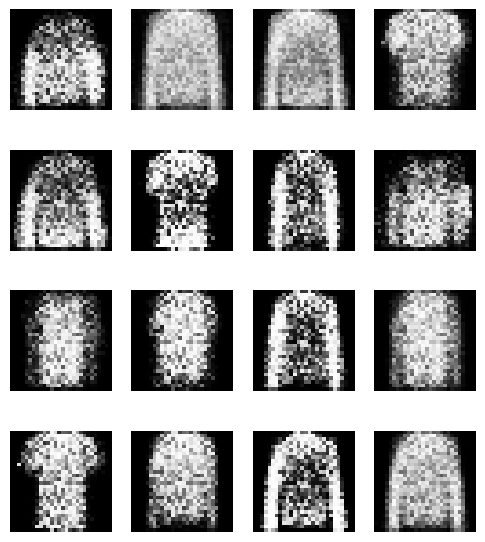

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [34]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x : 2 * x - 1)
            ])
dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

In [35]:
generator.load_state_dict(torch.load('./models/generator-010.pkl'))
discriminator.load_state_dict(torch.load('./models/discriminator-010.pkl'))

<All keys matched successfully>

In [36]:
inertia = []
normed_real_images = train.reshape(len(dataset), -1) / 255. * 2. - 1.
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(normed_real_images)
    inertia.append(model.inertia_)

AttributeError: 'FashionMNIST' object has no attribute 'reshape'

In [1]:
inertia_gan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(errG.reshape(60000, -1))
    inertia_gan.append(model.inertia_)

NameError: name 'errG' is not defined

In [ ]:
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters')

In [ ]:
# Critic
critic = nn.Sequential(
    nn.Linear(16 * 256, 784*400),
    nn.ReLU(inplace=True),
    nn.Linear(16*784, 4096*313600),
)

# Generator 
generator = nn.Sequential(
    nn.Linear(64, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.Sigmoid()
)

In [24]:
LR = 0.00005
N_EPOCHS = 300
N_CRITIC_STEPS = 5
CLAMP = 0.01

In [25]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

In [26]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [27]:
try: 
    for epoch in range(N_EPOCHS):
        crit_steps = 0
        
        for batch_number, (images, _) in enumerate(dataloader): 
            
            batch_size = images.shape[0] 

            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                err_real = torch.mean(critic(images))
            
                z = to_var(torch.randn(batch_size, 64))
                
                fake_images = generator(z)
                
                err_fake = torch.mean(critic(fake_images)) 
                
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                
                crit_steps += 1
            # 2) TRAIN GENERATOR
            else:
                critic.zero_grad()
                generator.zero_grad()

                z = to_var(torch.randn(batch_size, 64))
                
                fake_images = generator(z)
                
                outputs = critic(fake_images)
                
                generator_loss = -torch.mean(outputs)

                generator_loss.backward()
                generator_optimizer.step()
                
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            critic_loss.data[0],
                            generator_loss.data[0],
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28)
            save_image(denorm(images.data), './data/wgan_real_images.png')

        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        torch.save(generator.state_dict(), './models/wgan_generator-%0.3d.pkl' %(epoch + 1))
        torch.save(critic.state_dict(), './models/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print ('Training ended early.')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x784 and 4096x313600)

In [ ]:
generator.load_state_dict(torch.load('./models/wgan_generator-010.pkl'))
critic.load_state_dict(torch.load('./models/wgan_discriminator-010.pkl'))

In [ ]:
NB_SAMPLES = 400
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

In [ ]:
save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data),
           './data/wgan_fake_images_010.png', nrow=20)

In [ ]:
import IPython
IPython.display.Image('./data/wgan_fake_images_010.png')

In [ ]:
NB_SAMPLES = 60000
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

In [ ]:
inertia_wgan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(fake_images.data.numpy().reshape(60000, -1))
    inertia_wgan.append(model.inertia_)

In [ ]:
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.plot(range(2, 15), inertia_wgan, label='WGAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters')